# Modeling the result of a radio astronomy observation

This notebook uses the Julia package `RadioMdl.jl` to model the resulting power
levels seen by a radio telescope - the Westford antenna - when observing an
astronomical object such as Cas A.

In [ ]:
#
# TODO: change the Pkg.activate() path accordingly
#

import Pkg
Pkg.activate("C:/NatHaz/DK/CRC/SpectrumX/cursor_test/opti1/RadioMdl")
Pkg.instantiate()
Pkg.status()

# need to install PyPlot as it is not at original Project.tomi
Pkg.add("PyPlot")
Pkg.add("Revise")

  Activating project at `C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl`
Precompiling packages...
   5002.0 ms  ✓ RadioMdl
  1 dependency successfully precompiled in 10 seconds. 91 already precompiled.


Project RadioMdl v0.1.0
Status `C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\Project.toml`
  [69666777] Arrow v2.8.0
  [336ed68f] CSV v0.10.15
  [a93c6f00] DataFrames v1.7.0
  [8bb1440f] DelimitedFiles v1.9.1
  [a98d9a8b] Interpolations v0.16.1
  [d330b81b] PyPlot v2.11.6
⌃ [295af30f] Revise v3.8.0
  [592b5752] Trapz v2.0.3
  [ade2ca70] Dates
Info Packages marked with ⌃ have new versions available and may be upgradable.


   Resolving package versions...
  No Changes to `C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\Project.toml`
  No Changes to `C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\Project.toml`
  No Changes to `C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\Manifest.toml`


In [ ]:
using DataFrames
using Dates
using PyPlot
const plt = PyPlot

using Revise
using RadioMdl

using Serialization

## Define the instrument used to observe
---


### The antenna

The first step to define the instrument of observation is to define the antenna
used. The package has a custom structure `Antenna` that takes as inputs a
`DataFrame` structure with columns `:alphas`, `:betas` and `:gains`, containing
the gain values and their angle coordinates ($\alpha$,$\beta$), the estimated
radiation efficiency and the frequency band where the model of antenna defined
is valid. $\alpha\in[0,180]$ and $\beta\in[0,360[$ are defined such that when
the antenna is pointing at the horizon, $\beta=0$ gives a vertical slice of the
pattern, with $\alpha>0$ oriented towards the ground.

A path to a `.cut` file defining the power pattern model can be given in place
of the `DataFrame` structure to load and format the gain pattern. In that case,
it is possible to give the tags of the different columns if other names are
present in the table to load.

In [ ]:
# radiation efficiency of telescope antenna
eta_rad = .45

# valid frequency band of gain pattern model
freq_band = (10e9, 12e9) # in Hz

# load telescope antenna
file_pattern_path = joinpath(@__DIR__, "..", "src", "python", "data", "single_cut_res.cut")

tel_ant = Antenna(file_pattern_path, eta_rad, freq_band;
                            power_tag=:power,
                            declination_tag=:alpha,
                            azimuth_tag=:beta);

┌ Warning: This function assumes Daniel Sheen generated files
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\io.jl:46


shape of rad_pow: (1152064,)
shape of rad_pow_map: (18001, 65)
rad_pow_avg: 0.0013305498644795714


The result is a `Antenna` storing the different information and an interpolated
version of the gain pattern.

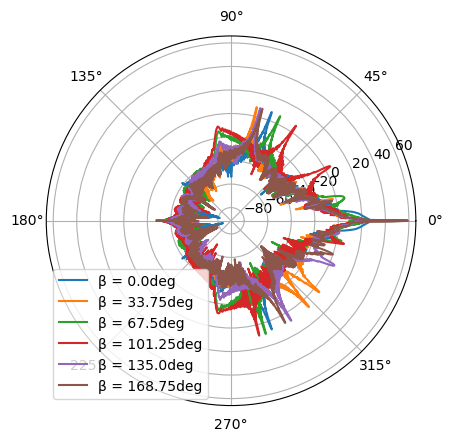

In [ ]:
# plot gain pattern
nb_curv = 5 # number of slices to plot
alphas, betas = get_def_angles(tel_ant) # angles where gain is defined by the file
step_beta_ind = div(length(betas), 2*nb_curv)
fig, axs = plt.subplots(subplot_kw=Dict("projection"=>"polar"))
for i in 1:step_beta_ind:div(length(betas), 2)
    alphas, gains = get_slice_gain(tel_ant, betas[i])
    axs.plot(deg2rad.(alphas), 10 .*log10.(gains), label="β = $(betas[i])deg")
end
axs.legend()
display(gcf())

### The instrument

To define the `Instrument` of observation as a structure, we need an `Antenna`
structure, as well as other parameters:
- the physical temperature of the antenna;
- the frequency of observation;
- the bandwidth of the instrument;
- the receiver temperature as a function of time (`DateTime` type) and frequency;
It is also possible to specify:
- the number of frequency channels to divide the bandwidth of the instrument by
  (default is 1);
- the coordinates of the instrument as a vector (not used as of now);

In [ ]:
# telescope antenna physical temperature
T_phy = 300.0 # in K

# frequency of observation
cent_freq = 11.325e9 # in Hz

# bandwidth of telescope receiver
bw = 1e3 # in Hz

# number of frequency channels to devide the bandwidth
freq_chan = 1

# telescope receiver temperature (constant over the bandwidth)
T_RX(tim::DateTime, cent_freq::Real) = 80.0 # in K

# coordinates of telescope
coords = [42.6129479883915, -71.49379366344017, 86.7689687917009]

# create instrument
westford = Instrument(tel_ant, T_phy, cent_freq, bw, T_RX, freq_chan, coords);

## Define the observation plan
---

The next step is to define the observation plan and conditions.


### The pointing trajectory during the observation

It is possible to load an already computed table of pointing directions. For
instance, an `.arrow` file containing the position of Cas A over a window of
time. The package defines a `Trajectory` structure that formats a `DataFrame` to
be used thereafter.

`Trajectory` can receive the path to an `.arrow` or `.csv` file instead of the
`DataFrame` to load an existing file. In that case, it is possible to give the
tags of the different columns if other names are present in the table to load.

In [ ]:
# time window of generated source trajectory
start_window = "2025-02-18T15:00:00.000"
stop_window = "2025-02-18T15:45:00.000"

# source position over time window
start_window_str = replace(start_window, ":" => "_")
stop_window_str = replace(stop_window, ":" => "_")

file_traj_obj_path = joinpath(@__DIR__, "..", "src", "python", "data", "casA_trajectory_Westford_$(start_window_str)_$(stop_window_str).arrow")


traj_src = Trajectory(file_traj_obj_path;
                      time_tag = :time_stamps,
                      elevation_tag = :altitudes,
                      azimuth_tag = :azimuths,
                      distance_tag = :distances);

To be more realistic, say the observation lasted 10min, with 5min offset and
5min on source, excluding any points that could be below 5deg elevation:

In [ ]:
# start-end of observation
dateformat = "yyyy-mm-dd\\THH:MM:SS.sss"
start_obs = DateTime("2025-02-18T15:30:00.000", dateformat)
stop_obs = DateTime("2025-02-18T15:40:00.000", dateformat)

# offset from source at the beginning of the observation
offset_angles = (-40, 0.) # (az,el) in degrees

# time of OFF-ON transition
time_off_src = start_obs
time_on_src = time_off_src + Minute(5)

# copy trajectory
traj_obj = Trajectory(copy(traj_src.traj))

# apply offset
traj_off_ind = findall(time_off_src .<= traj_obj.traj[!,:times] .<= time_on_src)
traj_obj.traj[traj_off_ind,:azimuths] .+= offset_angles[1]
traj_obj.traj[traj_off_ind,:elevations] .+= offset_angles[2]

# filter points below 5deg elevation
filt_el = (:elevations => e -> e .> 5.)

# create observation
observ = Observation(start_obs, stop_obs, traj_obj, westford;
                     filt_funcs = (filt_el,));

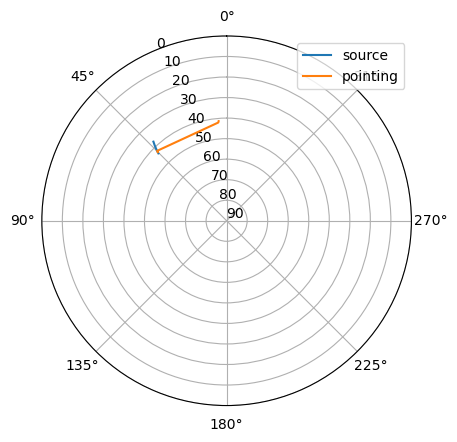

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, polar=true)
src_traj = get_traj(traj_src)
obs_traj = get_traj(observ)
ax.plot(deg2rad.(src_traj[!,:azimuths]), [90 .- s4 for s4 in src_traj[!,:elevations]],
        label="source")
ax.plot(deg2rad.(obs_traj[!,:azimuths]), [90 .- s4 for s4 in obs_traj[!,:elevations]],
        label="pointing")
ax.set_yticks(0:10:90, string.(Vector(90:-10:0)))
ax.legend()
ax.set_theta_zero_location("N")
display(gcf())

### Sky model

Accounting for the sky components is important to have a realistic simulation of
the power received.

Given the fact that we will point at Cas A for a part of the observation, we
need to account for the difference of temperature depending on the pointing position:

In [ ]:
#source flux
flux_src = estim_casA_flux(cent_freq) # in Jy

# source temperature in K
function T_src(t::DateTime)
    if t <= time_on_src
        return 0.
    else
        return estim_temp(flux_src, observ)
    end
end

T_src (generic function with 1 method)

Same for the RFI and the background sources that can be modeled as constants as a first approximation:

In [ ]:
# ground temperature in K
T_gnd = 0 # no constant RFI

# various RFI
T_var = 0 # in K (no RFI)

# total RFI temperature
T_rfi = T_gnd + T_var

# CMB temperature
T_CMB = 2.73 # in K

# galaxy temperature
T_gal(freq::Real) = 1e-1 * (freq/1.41e9)^(-2.7) # in K

# background
T_bkg(freq::Real) = T_CMB + T_gal(freq)

T_bkg (generic function with 1 method)

The atmosphere is also important to account for:

In [ ]:
# atmospheric temperature at zenith
T_atm_zenith = 150 # in K

# opacity of atmosphere at zenith
tau = .05

# atmospheric temperature model
T_atm(dec::Real) = T_atm_zenith * (1 - exp(-tau/cos(dec))) # in K

T_atm (generic function with 1 method)

Adding up all of these sources gives:

In [ ]:
# Total sky model in K
function sky_mdl(dec::T,
    caz::T,
    tim::DateTime,
    freq::T) where {T<:Real}
    return T_src(tim) + T_atm(dec) + T_rfi + T_bkg(freq)
end

sky_mdl (generic function with 1 method)

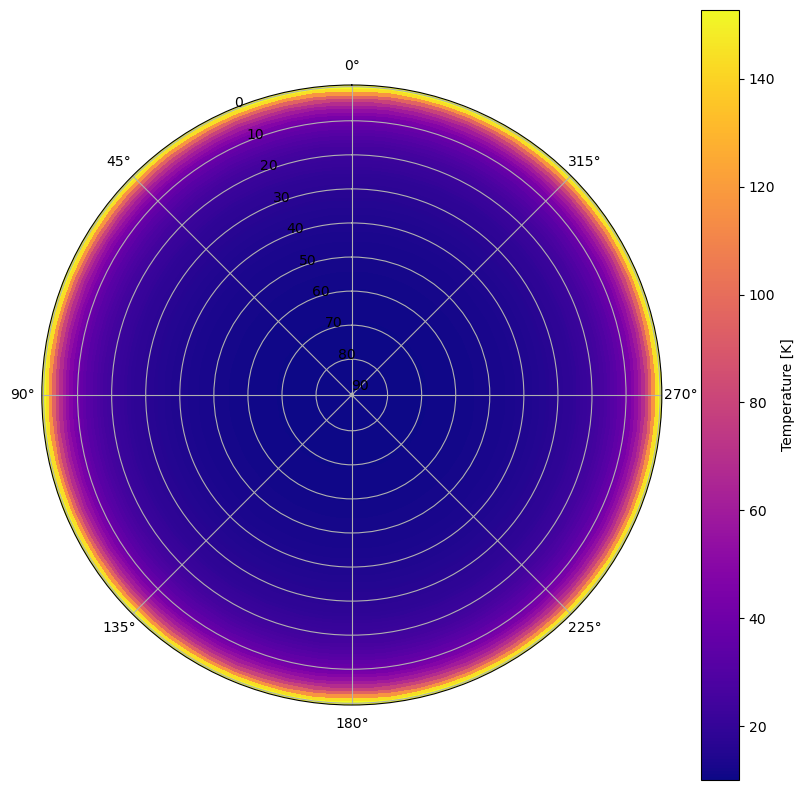

In [ ]:
# plot of sky model without source
azimuth_grid = collect(0.:5.:360.)
elevation_grid = collect(0.:1.:90.)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, polar=true)
pc = pcolormesh(deg2rad.(azimuth_grid), 90 .- elevation_grid, sky_mdl.(deg2rad.(90 .-elevation_grid), -deg2rad.(azimuth_grid)', start_obs, cent_freq), cmap="plasma")
cbar = plt.colorbar(pc)
cbar.set_label("Temperature [K]")
ax.set_yticks(0:10:90, string.(Vector(90:-10:0)))
ax.set_theta_zero_location("N")
display(gcf())

## Satellite constellations
--- 
The package also defines a structure `Constellation` to account for aggregated
power from satellites.

### Antenna model

The first step is to define the antenna model for the type of satellites in the
constellation, as for instance the ITU recommended gain model.

Note that in the following, the satellites coordinate frame is supposed to be
following (North, East, Nadir).

In [ ]:
# radiation efficiency of telescope antenna
sat_eta_rad = .5 #FIXME:check value

#
# maximum gain of satellite antenna
sat_gain_max = 39.3 # in dBi #FIXME:check value in dBi

# create ITU recommended gain profile
# satelitte boresight half beamwidth
half_beamwidth = 3. # in deg #FIXME:check value
# declination angles alpha
alphas = 0.:1.:180.
# azimuth angles beta
betas = 0.:10.:350.
# create gain dataframe
gain_pat = antenna_mdl_ITU(sat_gain_max, half_beamwidth, alphas, betas)

# create satellite antenna
sat_ant = Antenna(gain_pat, sat_eta_rad, freq_band);

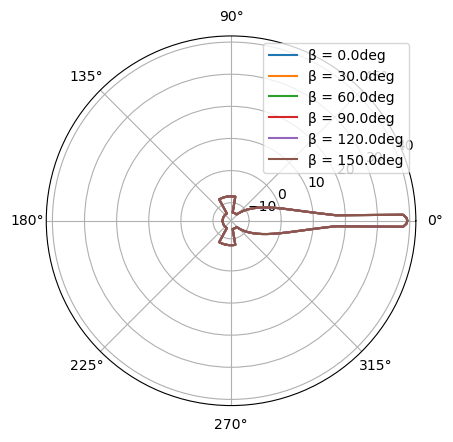

In [ ]:
# plot gain pattern
nb_curv = 5 # number of slices to plot
alphas, betas = get_def_angles(sat_ant) # angles where gain is defined by the file
step_beta_ind = div(length(betas), 2*nb_curv)
fig, axs = plt.subplots(subplot_kw=Dict("projection"=>"polar"))
for i in 1:step_beta_ind:div(length(betas), 2)
    alphas, gains = get_slice_gain(sat_ant, betas[i])
    axs.plot(deg2rad.(alphas), 10 .*log10.(gains), label="β = $(betas[i])deg")
end
axs.legend()
display(gcf())

### Transmitter parameters

The satellites are transmitting information and can be defined as an
`Instrument` structure:

In [ ]:
# telescope antenna physical temperature
sat_T_phy = 0. # in K

# frequency of transmition
sat_freq = 11.325e9 # in Hz

# satellite transmition bandwidth
sat_bw = 250e6 # in Hz

# satellite effective isotropically radiated power
transmit_pow = -15+10*log10(300) # in dBW #FIXME:check value
function transmit_temp(tim::DateTime,
    freq::Real)

    return power_to_temperature(10^(transmit_pow/10), 1.)#sat_bw) # in K
end

# create transmitter instrument
sat_transmit = Instrument(sat_ant, sat_T_phy, sat_freq, sat_bw, transmit_temp);

### Constellation

Taking a pre-generated file containing the trajectory of each satellite at each
time samples of the observation. The `Constellation` structure takes as input
the path to this file, the `Observation` structure and the `Instrument` with which
the satellites are transmitting.

The structure can take the tags of the columns of the table and additional
filters:

In [ ]:
# filter the satellites
filt_name = (:sat => s -> .!contains.(s, "[DTC]"))
filt_el = (:elevations => e -> e .> 20)

# satellite link budget estimator
lnk_bdgt(args...) = sat_link_budget(args...; beam_avoid = 0., turn_off = false)

# satellites trajectories during the observation
file_traj_sats_path = joinpath(@__DIR__, "..", "src", "python", "data", "Starlink_trajectory_Westford_$(start_window_str)_$(stop_window_str).arrow")

starlink_constellation = Constellation(file_traj_sats_path, observ, sat_transmit,
                                       lnk_bdgt;
                                       name_tag = :sat,
                                       time_tag = :timestamp,
                                       elevation_tag = :elevations,
                                       azimuth_tag = :azimuths,
                                       distance_tag = :ranges_westford,
                                       filt_funcs = (filt_name, filt_el));

┌ Warning: Observation time stamps and Constellation time stamps needsto be aligned.
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\types.jl:376


201

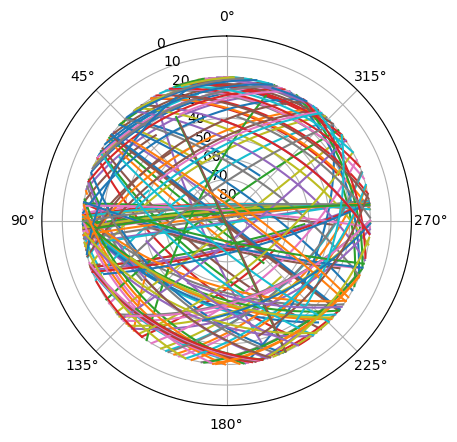

In [ ]:
# check number of satellites
display(length(get_sats_name(starlink_constellation)))

list_sats = get_sats_name(starlink_constellation)
sel_sats = 1:length(list_sats)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, polar=true)
for s in list_sats[sel_sats]
    sat = get_sat_traj(starlink_constellation, s)
    ax.plot(deg2rad.(sat[:,:azimuths]), 90 .- sat[:,:elevations])
end
ax.set_yticks(0:10:90, string.(Vector(90:-10:0)))
ax.set_theta_zero_location("N")
display(gcf())

## Model total power received during observation
---

The `model_observed_temp!` takes as input the `Observation` and can also take a
`sky_mdl` function and one or a vector of `Constellation`. 

In [ ]:
model_observed_temp!(observ, sky_mdl, starlink_constellation);

┌ Warning: There may be an issue in terms of absolute temperature (bandwith scaling?)
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\obs_mdl.jl:13


The method also have a keyword `beam_avoid` that takes an angle value. If the
angle between the boresight of a satellite and the telescope pointing direction
is below this angle, the satellite "steers" away of 45deg.

In [ ]:
obs_beam_avoid = Observation(start_obs, stop_obs, traj_obj, westford)

lnk_bdgt_beam_avoid(args...) = sat_link_budget(args...; beam_avoid = 10.,
                                               turn_off = false)
starlink_const_beam_avoid = Constellation(file_traj_sats_path, observ, sat_transmit,
                                          lnk_bdgt_beam_avoid;
                                          name_tag = :sat,
                                          time_tag = :timestamp,
                                          elevation_tag = :elevations,
                                          azimuth_tag = :azimuths,
                                          distance_tag = :ranges_westford,
                                          filt_funcs = (filt_name, filt_el))
model_observed_temp!(obs_beam_avoid, sky_mdl, starlink_const_beam_avoid);

┌ Warning: Observation time stamps and Constellation time stamps needsto be aligned.
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\types.jl:376
┌ Warning: There may be an issue in terms of absolute temperature (bandwith scaling?)
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\obs_mdl.jl:13


Without a satellite constellation:

In [ ]:
obs_src = Observation(start_obs, stop_obs, traj_obj, westford)
model_observed_temp!(obs_src, sky_mdl);

┌ Warning: There may be an issue in terms of absolute temperature (bandwith scaling?)
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\obs_mdl.jl:13


With a constellation of satellites that are omni-directional and low power:

In [ ]:
# create constant gain profile
# declination angles alpha
alphas = 0:1:180
# azimuth angles beta
betas = 0:10:350
# minimum gain from sats
sat_gain_min = minimum(sat_ant.gain_pat[!,:gains])
# create gain dataframe
gain_pat = DataFrame(alphas=zeros(length(alphas)*length(betas)),
                     betas=zeros(length(alphas)*length(betas)),
                     gains=zeros(length(alphas)*length(betas)))
for b in eachindex(betas)
    gain_pat[((b-1)*length(alphas)+1):b*length(alphas), :alphas] .= alphas
    gain_pat[((b-1)*length(alphas)+1):b*length(alphas), :betas] .= betas[b]
    gain_pat[((b-1)*length(alphas)+1):b*length(alphas), :gains] .= sat_gain_min
end
sat_cst_gain_ant = Antenna(gain_pat, sat_eta_rad, freq_band)
sat_cst_gain_transmit = Instrument(sat_cst_gain_ant, sat_T_phy, sat_freq, sat_bw,
                                   transmit_temp)
starlink_cst_gain_constellation = Constellation(file_traj_sats_path, observ,
                                                sat_cst_gain_transmit, lnk_bdgt;
                                                name_tag = :sat,
                                                time_tag = :timestamp,
                                                elevation_tag = :elevations,
                                                azimuth_tag = :azimuths,
                                                distance_tag = :ranges_westford,
                                                filt_funcs = (filt_name, filt_el))
obs_cst_sat_gain = Observation(start_obs, stop_obs, traj_obj, westford)
model_observed_temp!(obs_cst_sat_gain, sky_mdl, starlink_cst_gain_constellation);

┌ Warning: Observation time stamps and Constellation time stamps needsto be aligned.
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\types.jl:376
┌ Warning: There may be an issue in terms of absolute temperature (bandwith scaling?)
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\obs_mdl.jl:13


### Visualization

Visualizing the different results as total power over time:

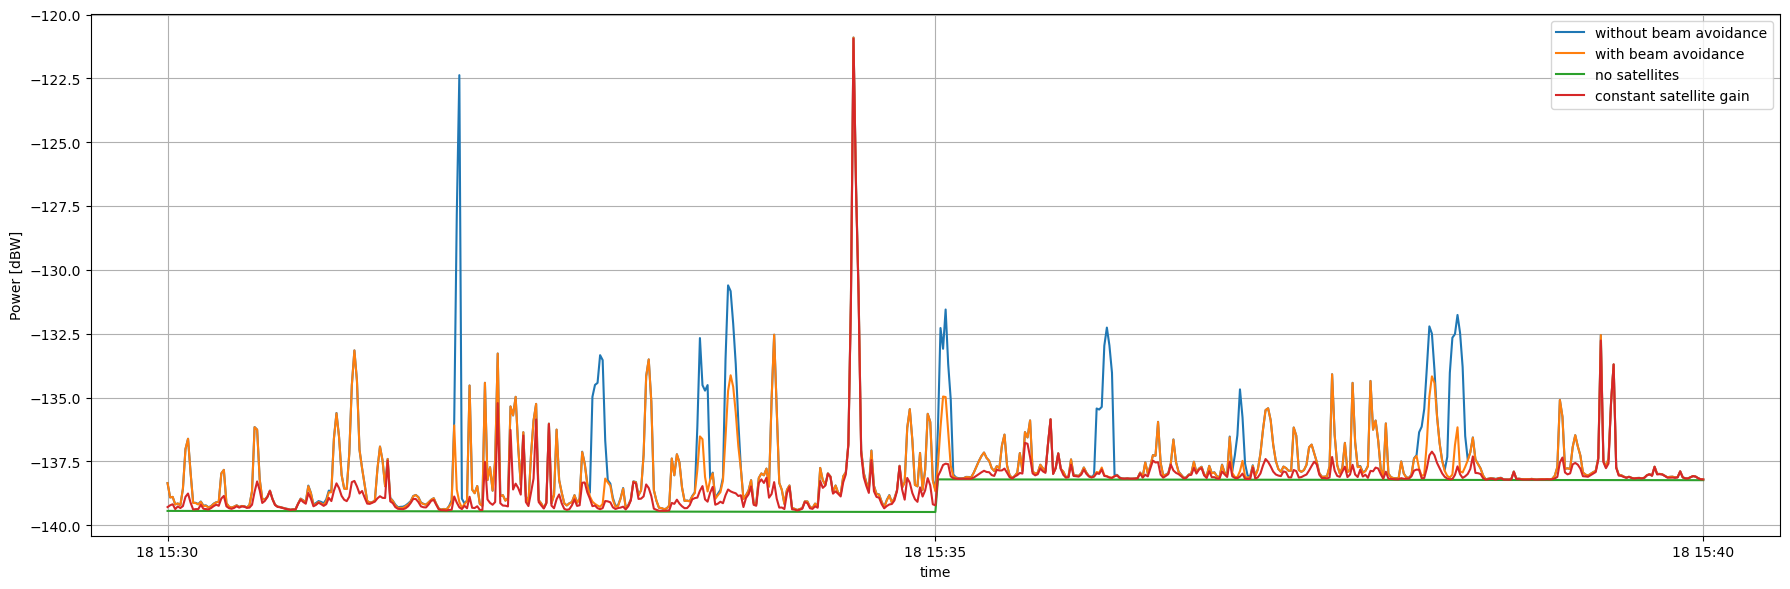

In [ ]:
fig, axs = plt.subplots(figsize=(18, 6))
# Observation without beam avoidance
time_samples = get_time_stamps(observ)
plot_result = temperature_to_power.(get_result(observ), bw)[:,1,1]
axs.plot(time_samples, 10 .*log10.(plot_result), label="without beam avoidance")
# Observation with beam avoidance
time_samples = get_time_stamps(obs_src)
plot_result = temperature_to_power.(get_result(obs_beam_avoid), bw)[:,1,1]
axs.plot(time_samples, 10 .*log10.(plot_result), label="with beam avoidance")
# Observation without constellation
time_samples = get_time_stamps(obs_src)
plot_result = temperature_to_power.(get_result(obs_src), bw)[:,1,1]
axs.plot(time_samples, 10 .*log10.(plot_result), label="no satellites")
# Observation with constellation of constant gain
time_samples = get_time_stamps(obs_cst_sat_gain)
plot_result = temperature_to_power.(get_result(obs_cst_sat_gain), bw)[:,1,1]
axs.plot(time_samples, 10 .*log10.(plot_result), label="constant satellite gain")
axs.legend()
axs.set_xlabel("time")
axs.set_ylabel("Power [dBW]")
axs.grid(true)
axs.legend()
fig.tight_layout()
display(gcf())

Focusing on a specific time to see where the satellites are located compare to
the pointing direction of the telescope:

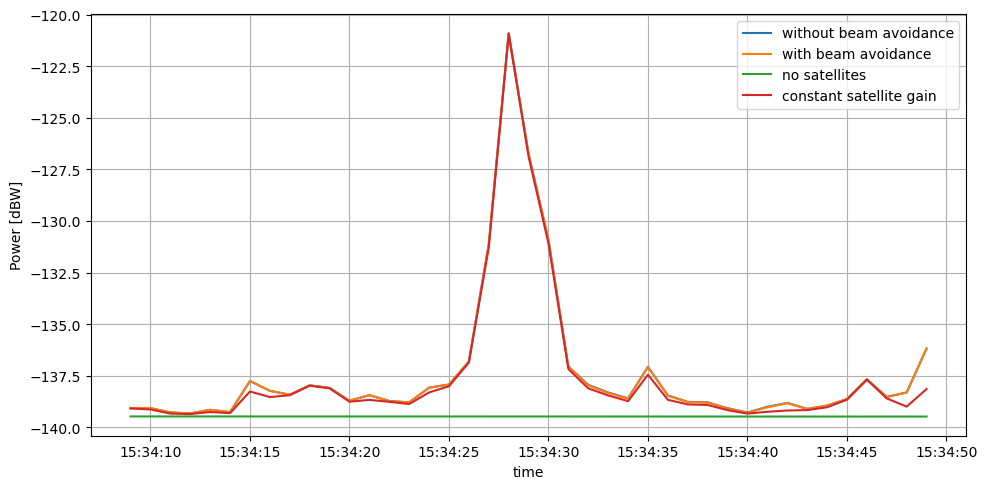

In [ ]:
# zoom dates
start_zoom = DateTime("2025-02-18T15:34:09.000", dateformat)
stop_zoom = DateTime("2025-02-18T15:34:49.000", dateformat)
time_samples = get_time_stamps(observ)
time_zoom = findall(start_zoom .<= time_samples .<= stop_zoom)

fig, axs = plt.subplots(figsize=(10, 5))
# Observation without beam avoidance
plot_result = temperature_to_power.(get_result(observ), bw)[time_zoom,1,1]
axs.plot(time_samples[time_zoom], 10 .*log10.(plot_result), label="without beam avoidance")
# Observation with beam avoidance
plot_result = temperature_to_power.(get_result(obs_beam_avoid), bw)[time_zoom,1,1]
axs.plot(time_samples[time_zoom], 10 .*log10.(plot_result), label="with beam avoidance")
# # Observation without constellation
plot_result = temperature_to_power.(get_result(obs_src), bw)[time_zoom,1,1]
axs.plot(time_samples[time_zoom], 10 .*log10.(plot_result), label="no satellites")
# # Observation with constellation of constant gain
plot_result = temperature_to_power.(get_result(obs_cst_sat_gain), bw)[time_zoom,1,1]
axs.plot(time_samples[time_zoom], 10 .*log10.(plot_result), label="constant satellite gain")
axs.legend()
axs.set_xlabel("time")
axs.set_ylabel("Power [dBW]")
axs.grid(true)
axs.legend()
fig.tight_layout()
display(gcf())

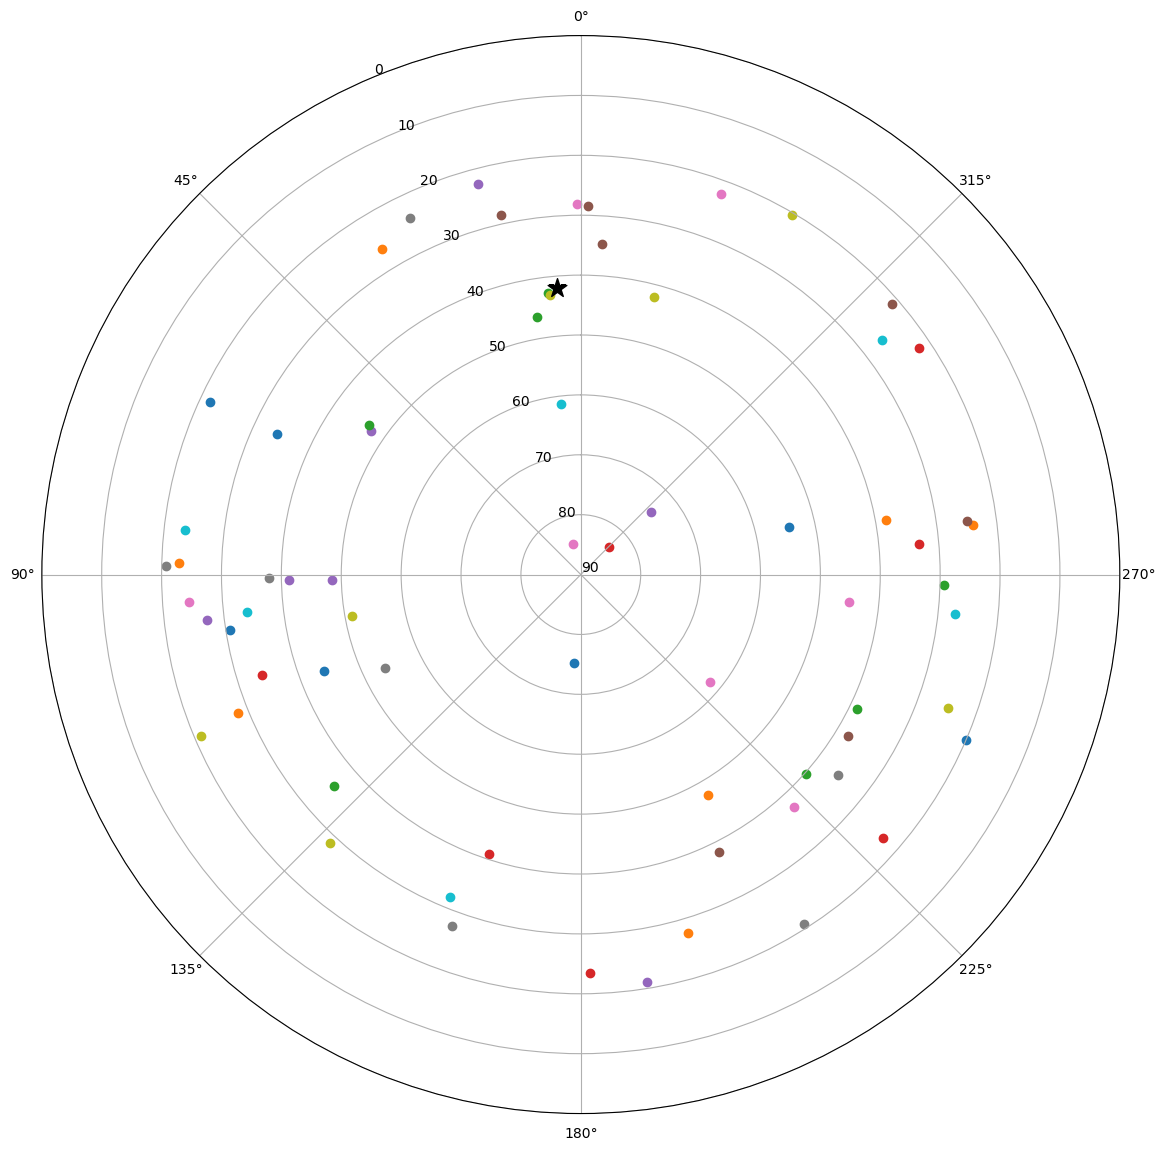

In [ ]:
time_study = DateTime("2025-02-18T15:34:29.000", dateformat)
sats_at_t = get_sats_names_at_time(starlink_constellation, time_study)

sel_sats = 1:length(sats_at_t)
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(1, 1, 1, polar=true)
for s in sats_at_t[sel_sats]
    sat = get_sat_traj(starlink_constellation, s)
    sat_pt = subset(sat, :times => t -> t .== time_study; view=true)
    # ax.plot(sat[:,:azimuths].*rad, 90 .- sat[:,:elevations])
    ax.scatter(deg2rad.(sat_pt[:,:azimuths]), 90 .- sat_pt[:,:elevations])
end
instru_pt = subset(get_traj(observ), :times => t -> t .== time_study; view=true)
ax.scatter(deg2rad.(instru_pt[:,:azimuths]), 90 .- instru_pt[:,:elevations],
           marker="*", c="black", s=2e2)
ax.set_yticks(0:10:90, string.(Vector(90:-10:0)))
ax.set_theta_zero_location("N")
display(gcf())

## Model Power Spectral Density during observation
---

The package is also capable of estimating the power for a wider bandwidth and
differnet frequency channels (PSD).


It is possible to increase the number of frequency channels that the simulator
can compute to visualize the PSD:

In [ ]:
# new instrument parameters
new_freq_chan = 164
new_bw = 30e6

# new instrument that simulate the PSD
westford_freqs = Instrument(tel_ant, T_phy, cent_freq, new_bw, T_RX, new_freq_chan,
                            coords);

# new observation
observ_freqs = Observation(start_obs, stop_obs, traj_obj, westford_freqs;
                           filt_funcs = (filt_el,));

Say we define a new transmission pattern from the satellites that depends on the frequency:

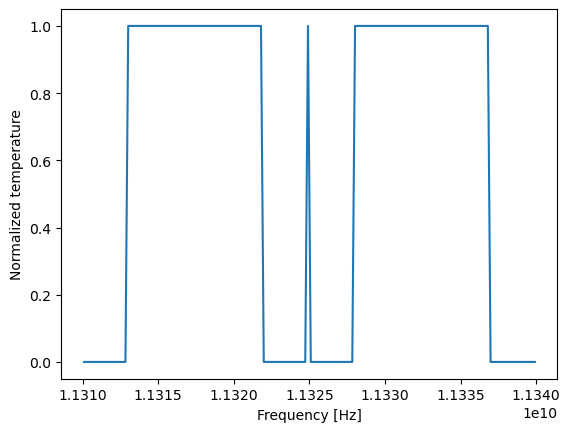

In [ ]:
# new satellite transmission model that depends on frequnecy
tmt_profile = ones(new_freq_chan)
tmt_profile[1:div(new_freq_chan, 10)] .= 0.
tmt_profile[end-div(new_freq_chan, 10):end] .= 0.
tmt_profile[div(new_freq_chan, 2) .+
            (-div(new_freq_chan, 10):div(new_freq_chan, 10))] .= 0.
tmt_profile[div(new_freq_chan, 2)] = 1.

freq_bins = get_center_freq_chans(westford_freqs)
function transmit_temp_freqs(tim::DateTime,
    freq::Real)

    ind_freq = findmin(abs.(freq_bins .- freq))[2]

    return tmt_profile[ind_freq] * power_to_temperature(10^(transmit_pow/10), 1.) # in K
end

figure()
plt.plot(freq_bins, tmt_profile)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalized temperature")
display(gcf())

The rest of the code is run the same way it was before:

In [ ]:
# create transmitter instrument
sat_transmit_freqs = Instrument(sat_ant, sat_T_phy, sat_freq, sat_bw, transmit_temp_freqs)

starlink_constellation_freqs = Constellation(file_traj_sats_path, observ_freqs, sat_transmit_freqs;
                                             name_tag = :sat,
                                             time_tag = :timestamp,
                                             elevation_tag = :elevations,
                                             azimuth_tag = :azimuths,
                                             distance_tag = :ranges_westford,
                                             filt_funcs = (filt_name, filt_el));

┌ Warning: Observation time stamps and Constellation time stamps needsto be aligned.
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\types.jl:376


In [ ]:
# there is no beam_avoid in the function model_observed_temp!
# model_observed_temp!(observ_freqs, sky_mdl, starlink_constellation_freqs; beam_avoid = 0.);

# compute observ_freqs directly
model_observed_temp!(observ_freqs, sky_mdl, starlink_constellation_freqs);

# # load observ_freqs from file to save time
# jls_path = joinpath(@__DIR__, "observ_freqs.jls")
# observ_freqs = deserialize(jls_path)

┌ Warning: There may be an issue in terms of absolute temperature (bandwith scaling?)
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\obs_mdl.jl:13


601×1×164 Array{Float64, 3}:
[:, :, 1] =
 824278.3788018964
 824251.2021953842
 824224.0282945776
 824196.8570992639
 824169.6886091608
 824142.5228240466
 824115.359743666
 824088.1993677708
 824061.0416961063
 824033.8867284494
      ⋮
      1.087742595570524e6
      1.0877169783550147e6
      1.0876913637032367e6
      1.0876657516149795e6
      1.0876401420899795e6
      1.087614535128036e6
      1.0875889307288867e6
      1.0875633288923285e6
      1.0875377296181e6

[:, :, 2] =
 824278.3778490598
 824251.2012425474
 824224.027341741
 824196.8561464272
 824169.6876563242
 824142.52187121
 824115.3587908292
 824088.1984149342
 824061.0407432697
 824033.8857756128
      ⋮
      1.0877425946176872e6
      1.0877169774021779e6
      1.0876913627503999e6
      1.0876657506621426e6
      1.087640141137143e6
      1.0876145341751995e6
      1.08758892977605e6
      1.087563327939492e6
      1.0875377286652634e6

[:, :, 3] =
 824278.3768962802
 824251.2002897679
 824224.0263889615
 824196

In [ ]:
time_samples = get_time_stamps(observ_freqs)
freq_bins = get_center_freq_chans(westford_freqs)
plot_psd = temperature_to_power.(get_result(observ_freqs),
                                 bw/freq_chan)[:,1,:]'
plot_pow = temperature_to_power.(get_result(observ), bw)[:,1,1];

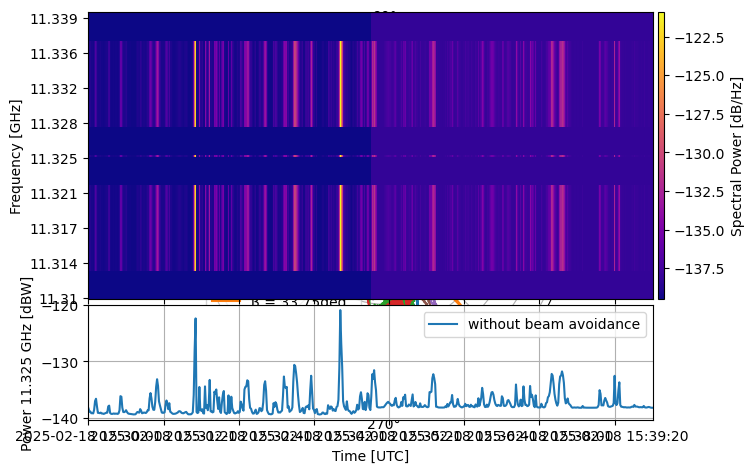

sys:1: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists


In [ ]:
plt.close()
fig = plt.figure(1, figsize=(16,8))
gs = plt.matplotlib.gridspec.GridSpec(2, 2, height_ratios=[1,.4],
                                      width_ratios=[1,.01])
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.02, hspace=0.03)

ax1 = plt.subplot(gs[1,1])
psd = ax1.imshow(10 .*log10.(plot_psd), interpolation="nearest", cmap="plasma",
                 aspect="auto")

ax1.set_xlim(-.5, size(plot_psd, 2) - .5)
ax1.set_ylim(-.5, size(plot_psd, 1) - .5)
ax1.set_xlabel("")
ax1.set_xticks(0:size(plot_psd, 2)-1)
ax1.set_xticklabels([])
ax1.xaxis.set_major_locator(PyPlot.matplotlib.ticker.MaxNLocator(integer=true))
ax1.set_yticks(0:size(plot_psd, 1)-1)
ax1.set_yticklabels(round.(freq_bins.*1e-9; digits=3))
ax1.yaxis.set_major_locator(PyPlot.matplotlib.ticker.MaxNLocator(integer=true))
ax1.set_ylabel("Frequency [GHz]")

cbax = plt.subplot(gs[1,2])
cb = plt.matplotlib.colorbar.Colorbar(ax=cbax, mappable=psd)
cb.set_label("Spectral Power [dB/Hz]")

ax2 = plt.subplot(gs[2,1])
ax2.plot(0:length(time_samples)-1, 10 .*log10.(plot_pow), label="without beam avoidance")

ax2.set_xlim(-.5, size(plot_psd, 2) - .5)
ax2.set_xticks(0:size(plot_psd, 2)-1)
ax2.set_xticklabels(time_samples)
ax2.xaxis.set_major_locator(PyPlot.matplotlib.ticker.MaxNLocator(integer=true))
ax2.set_xlabel("Time [UTC]")
ax2.set_ylabel("Power 11.325 GHz [dBW]")
ax2.grid(true)
ax2.legend()

display(gcf())

## Model total power over entire sky
---

The package also allows modeling the power received at each time samples for
multiple positions over the sky.

It is possible to define a `Trajectory` that points at the full sky over each
time samples:

In [ ]:
# sky map
azimuth_grid = collect(0.:5.:355.)
elevation_grid = collect(0.:1.:90.)

# trajectory over full sky
time_samples = get_time_stamps(observ)
points = DataFrame(times=DateTime[], azimuths=AbstractVector{Float64}[],
                   elevations=AbstractVector{Float64}[],
                   distances=AbstractVector{Float64}[])
azs = []
els = []
dists = []
for a in azimuth_grid
    append!(azs, a .* ones(length(elevation_grid)))
    append!(els, elevation_grid)
    append!(dists, Inf64 .*ones(length(elevation_grid)))
end
for t in time_samples
    push!(points, [t, azs, els, dists])
end

traj_sky = Trajectory(points);

Then the observation follows the same framework:

In [ ]:
# observation over full sky
start_obs_sky = DateTime("2025-02-18T15:34:24.000", dateformat)
stop_obs_sky = DateTime("2025-02-18T15:34:34.000", dateformat)
observ_sky = Observation(start_obs_sky, stop_obs_sky, traj_sky, westford);

With the new sky model:

In [ ]:
# source temperature in K
half_beamwidth_tel = 1. # in deg #FIXME:check value
function T_src(dec::T,
    caz::T,
    tim::DateTime,
    freq::T) where T

    # source position
    dec_src = pi/2 - deg2rad(traj_src.traj[traj_src.traj.times .== tim,:elevations][1])
    caz_src = -deg2rad(traj_src.traj[traj_src.traj.times .== tim,:azimuths][1])

    if abs(dec - dec_src) < deg2rad(half_beamwidth_tel) && abs(caz - caz_src) < deg2rad(half_beamwidth_tel)
        #source flux
        flux_src = estim_casA_flux(freq) # in Jy

        return estim_temp(flux_src, observ)
    else
        return 0.
    end
end

# Total sky model in K
function sky_mdl(dec::T,
    caz::T,
    tim::DateTime,
    freq::T) where {T<:Real}

    return T_src(dec, caz, tim, freq) + T_atm(dec) + T_rfi + T_bkg(freq)
end

sky_mdl (generic function with 1 method)

The simulation gives:

In [ ]:
# there is no beam_avoid in the function model_observed_temp!
# model_observed_temp!(observ_sky, sky_mdl, starlink_constellation; beam_avoid = 10.);

# compute observ_sky directly
model_observed_temp!(observ_sky, sky_mdl, starlink_constellation);

# # load observ_sky from file to save time
# jls_path = joinpath(@__DIR__, "observ_sky.jls")
# observ_sky = deserialize(jls_path)

┌ Warning: There may be an issue in terms of absolute temperature (bandwith scaling?)
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\obs_mdl.jl:13


11×6552×1 Array{Float64, 3}:
[:, :, 1] =
 9.21809e6  8.70191e6  7.06153e6  …  5.40689e6  3.33263e6  2.03618e6
 9.2182e6   8.70486e6  7.06189e6     5.75977e6  4.54964e6  3.59064e6
 9.21872e6  8.70542e6  7.06117e6     1.66903e7  8.10972e6  6.51038e6
 9.21921e6  8.70508e6  7.0632e6      6.87676e8  2.29748e8  3.46636e7
 9.21907e6  8.70644e6  7.06584e6     2.90005e7  1.09318e7  2.5102e7
 9.22022e6  8.71045e6  7.06379e6  …  2.42273e7  1.55316e7  6.08083e6
 9.21907e6  8.7069e6   7.06207e6     1.61624e7  1.62781e7  8.08387e6
 9.22317e6  8.70763e6  7.07194e6     1.81089e8  1.62162e7  1.47193e7
 9.22102e6  8.70593e6  7.06854e6     6.08375e7  2.69555e7  1.45096e7
 9.22301e6  8.71289e6  7.08683e6     1.62253e7  3.7087e7   8.7314e6
 9.22034e6  8.71096e6  7.09113e6  …  3.12399e7  1.96166e7  3.13156e7

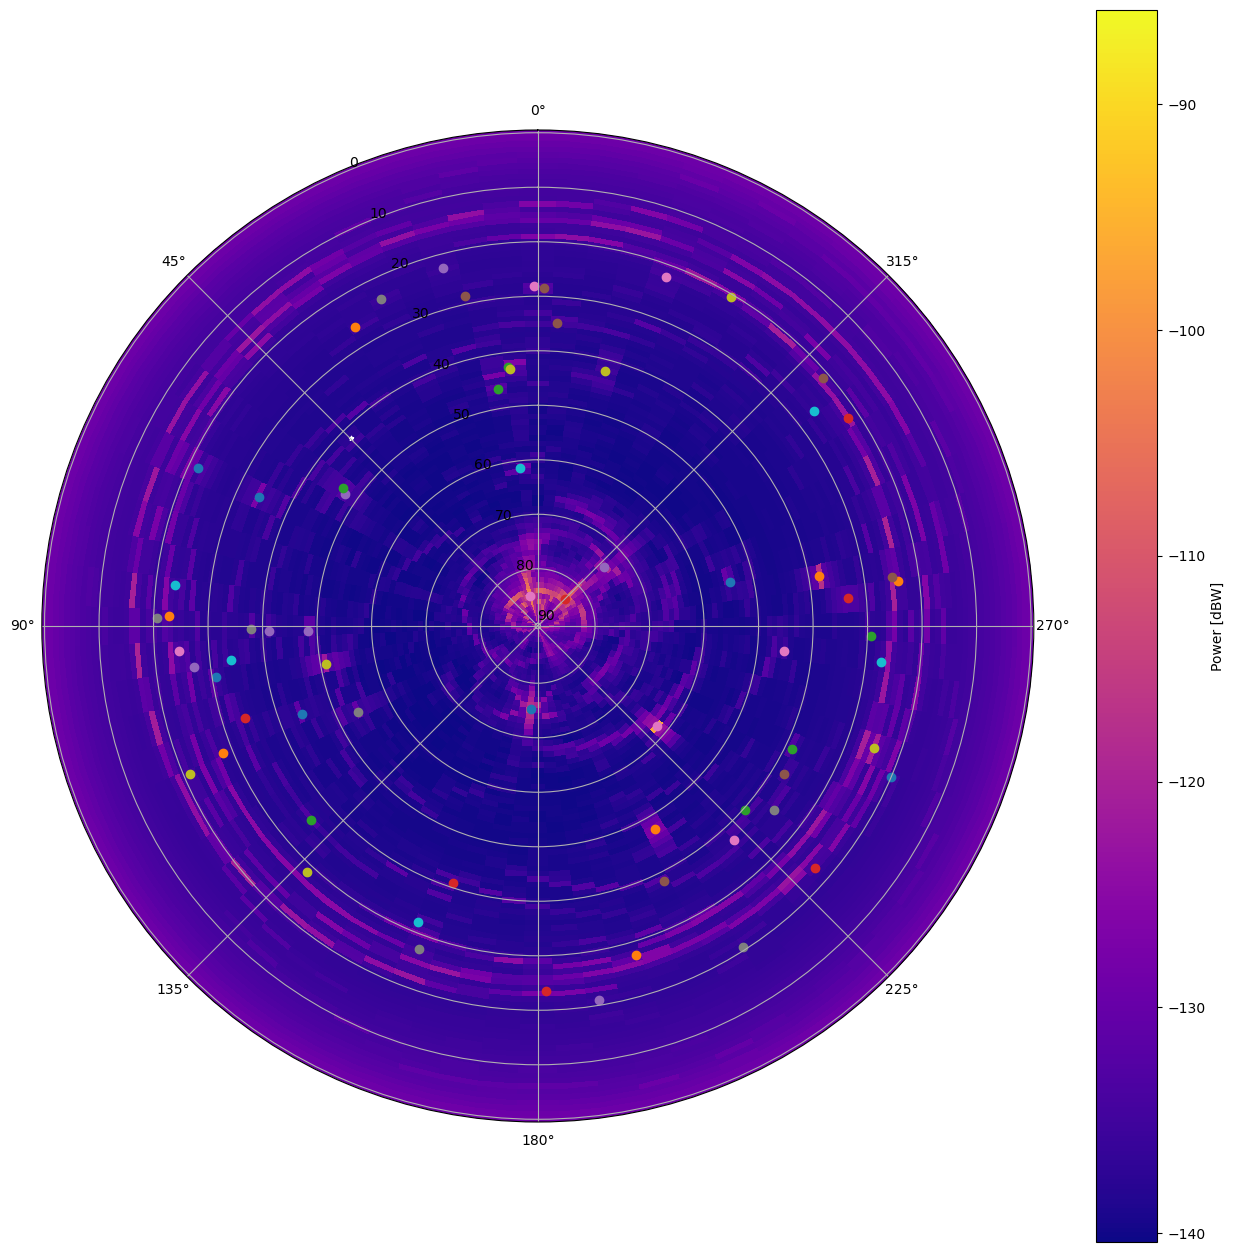

In [ ]:
time_plot = DateTime("2025-02-18T15:34:29.000", dateformat)
time_samples = get_time_stamps(observ_sky)
time_ind = findall(time_samples .== time_plot)[1]
map, e, a = map_sphere(get_result(observ_sky)[time_ind,:,1], elevation_grid, azimuth_grid)

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 1, 1, polar=true)

pc = pcolormesh(a, 90 .- rad2deg.(e), 10 .*log10.(temperature_to_power.(map, bw)),
                cmap="plasma")
cbar = plt.colorbar(pc)
cbar.set_label("Power [dBW]")

sats_at_t = get_sats_names_at_time(starlink_constellation, time_plot)
sel_sats = 1:length(sats_at_t)
for s in sats_at_t[sel_sats]
    sat = get_sat_traj(starlink_constellation, s)
    sat_pt = subset(sat, :times => t -> t .== time_plot; view=true)
    ax.scatter(deg2rad.(sat_pt[:,:azimuths]), 90 .- sat_pt[:,:elevations])
end
src_pt = subset(get_traj(traj_src), :times => t -> t .== time_plot; view=true)
ax.scatter(deg2rad.(src_pt[:,:azimuths]), 90 .- src_pt[:,:elevations],
           marker="*", c="white", s=1e1)
ax.set_yticks(0:10:90, string.(Vector(90:-10:0)))
ax.set_theta_zero_location("N")
display(gcf())

And without accounting for satellites:

In [ ]:
observ_sky_no_sat = Observation(start_obs_sky, stop_obs_sky, traj_sky, westford);
model_observed_temp!(observ_sky_no_sat, sky_mdl);

┌ Warning: There may be an issue in terms of absolute temperature (bandwith scaling?)
└ @ RadioMdl C:\NatHaz\DK\CRC\SpectrumX\cursor_test\opti1\RadioMdl\src\obs_mdl.jl:13


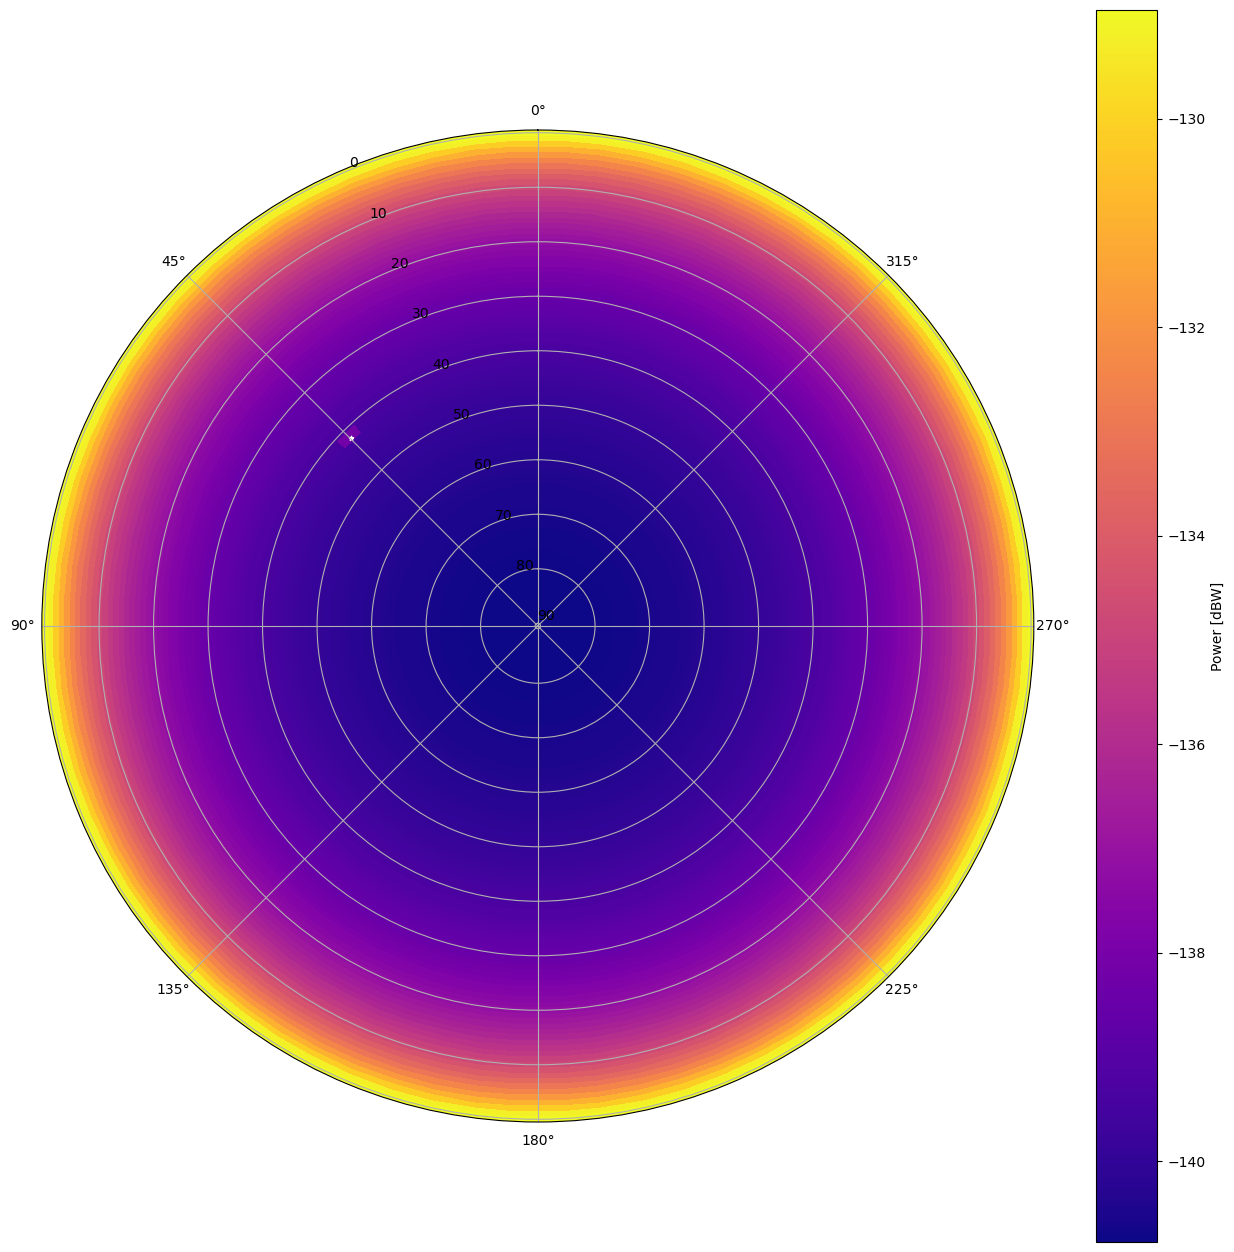

In [ ]:

time_plot = DateTime("2025-02-18T15:34:29.000", dateformat)
time_samples = get_time_stamps(observ_sky_no_sat)
time_ind = findall(time_samples .== time_plot)[1]
map, e, a = map_sphere(get_result(observ_sky_no_sat)[time_ind,:,1], elevation_grid, azimuth_grid)

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 1, 1, polar=true)

pc = pcolormesh(a, 90 .- rad2deg.(e), 10 .*log10.(temperature_to_power.(map, bw)), cmap="plasma")
cbar = plt.colorbar(pc)
cbar.set_label("Power [dBW]")

src_pt = subset(get_traj(traj_src), :times => t -> t .== time_plot; view=true)
ax.scatter(deg2rad.(src_pt[:,:azimuths]), 90 .- src_pt[:,:elevations],
           marker="*", c="white", s=1e1)
ax.set_yticks(0:10:90, string.(Vector(90:-10:0)))
ax.set_theta_zero_location("N")
display(gcf())